In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer

# READ DF + NORMALIZE

In [2]:
df = pd.read_csv("marketing_encoded_new.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
quantile_trans = QuantileTransformer(n_quantiles=df.shape[0], output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,total_products,frequent_purchases,total_child,age
0,-0.341494,0.253931,0.241678,0.245759,0.573746,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.401135,1.240208,-5.199338,0.848089
1,-0.341494,0.253931,-0.183793,-0.274439,-0.213804,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-1.477643,-1.022496,1.195084,1.120966
2,-0.341494,0.977712,0.831985,-0.615614,-0.514687,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.371038,0.674845,-5.199338,0.341494
3,-0.341494,0.977712,-1.141349,-0.615614,0.135648,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.891874,-0.616983,0.095203,-1.241430
4,5.199338,-0.523102,0.245176,1.637241,-0.213804,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.042450,0.423702,0.095203,-0.983202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,-0.341494,-0.523102,0.348100,-0.098046,-0.213804,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.040800,0.315218,0.095203,0.213804
2212,5.199338,0.977712,0.471869,0.188398,0.573746,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,-5.199338,0.074759,0.814515,5.199338,2.166824
2213,-0.341494,-1.603594,0.195315,1.381768,0.135648,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.931310,0.423702,-5.199338,-0.983202
2214,0.526349,0.977712,0.707174,-1.351536,-0.811366,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.438605,0.965917,0.095203,0.928695


# Robust Trimmed K Means


In [3]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMethods import *

#generate data RTKM untuk comply dengan func silhouette score
def generate_data_RTKM(dataframe, k, percent_outliers, num_members):
    dataframe_np_transposed = dataframe.to_numpy().T

    RTKM_data = RTKM(dataframe_np_transposed)
    RTKM_data.perform_clustering(k=k, percent_outliers = percent_outliers, max_iter = 100, num_members = num_members)
    print(k, percent_outliers, num_members)
    
    #pred clusters return cluster id for data index, pred outliers return outlier index
    pred_clusters, pred_outliers = RTKM_data.return_clusters()

    #Append dataset sehingga mendapatkan id
    cluster_id_RTKM = pd.DataFrame(pred_clusters, columns=['cluster_id'])
    RTKM_result = pd.merge(df_scaled, cluster_id_RTKM, left_index=True, right_index=True)

    # Create a mask for the indices in the DataFrame that need to be modified
    mask = np.isin(RTKM_result.index, pred_outliers)

    # Use np.where to conditionally replace values in cluster_id
    RTKM_result['cluster_id'] = np.where(mask, RTKM_result['cluster_id'].astype(str) + '-out', RTKM_result['cluster_id'])
    all_data = RTKM_result

    # Use boolean indexing to filter out rows based on indices_to_remove
    filtered_data = RTKM_result[~RTKM_result.index.isin(pred_outliers)]
    
    return filtered_data, all_data

# TEST RTKM ALGORITHM with K = 2 and n_percentage = 10

3 0.1 2


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

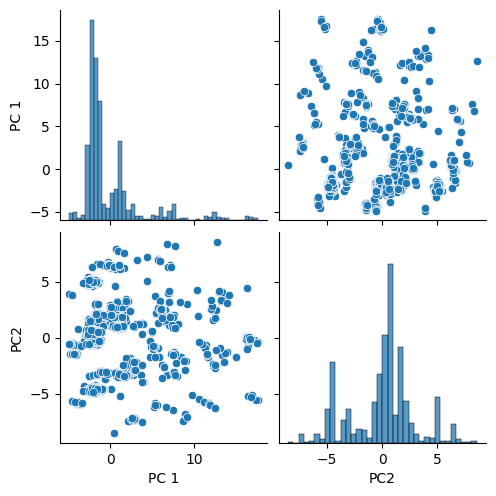

<Figure size 800x800 with 0 Axes>

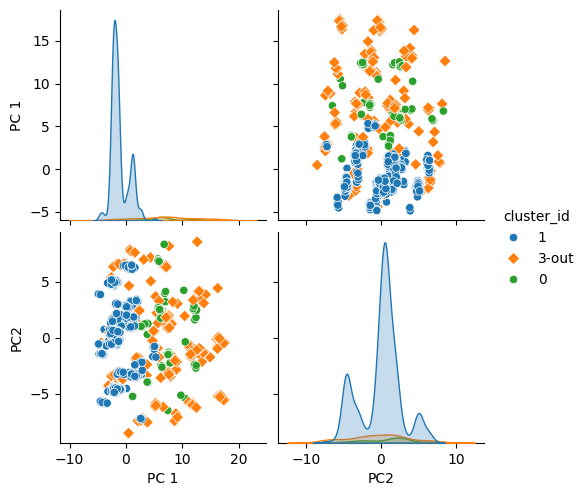

<Figure size 800x800 with 0 Axes>

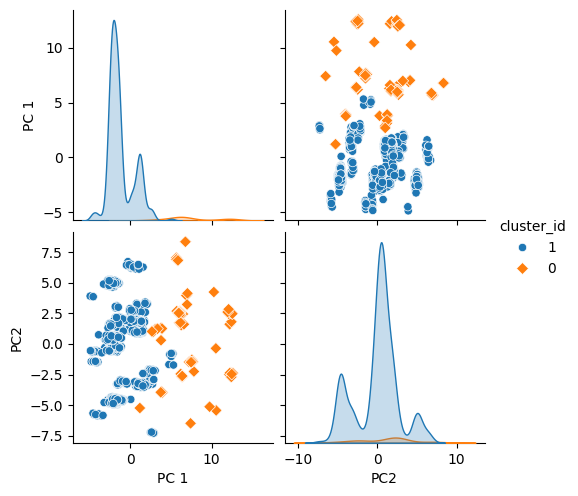

In [10]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 
from sklearn.metrics import silhouette_score

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# GET inliers (RTKM_result_filtered) and optimal cluster (RTKM_result)
RTKM_result_filtered, RTKM_result = generate_data_RTKM(df_scaled, 3, 0.10, 2)

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = RTKM_result.loc[:, RTKM_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = RTKM_result_filtered.loc[:, RTKM_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

In [11]:
#FIND SILHOUETTE SCORE
score = silhouette_score(RTKM_result_filtered.drop(['cluster_id'], axis=1), RTKM_result_filtered['cluster_id'])

print(score)

0.5101017628561517


## OPTIMAL PERCENTAGE

In [14]:
from sklearn.metrics import silhouette_score

# Function find optimal RTKM cluster
def find_optimal_RTKM(df, n_cluster):
    best_score = -1
    best_percent = 0
    best_cluster = None
    best_all = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)

        # Jalankan RTKM dengan parameter tertentu
        retry_count = 0
        max_retries = 5  # Tentukan jumlah maksimum percobaan

        while retry_count < max_retries:
            inliers, all_data = generate_data_RTKM(df, n_cluster, percent / 100, 2)
            inliers_no_id = inliers.drop(['cluster_id'], axis=1)

            print(inliers.shape)

            # Skip invalid data
            if inliers["cluster_id"].nunique() == 1:
                print("Invalid data, retrying...")
                retry_count += 1
                continue

            # Hitung skor siluet
            score = silhouette_score(inliers_no_id, inliers['cluster_id'])
            print("Score:", score)

            if inliers["cluster_id"].nunique() != n_cluster:
                print("NOTE THAT THE CENTROID DOES NOT MATCH K VALUE")

            # Perbarui parameter terbaik jika skor lebih tinggi
            if score > best_score:
                best_score = score
                best_percent = percent
                best_cluster = inliers
                best_all = all_data

            break  # Keluar dari loop retry jika data valid
    
    print("====================================================")
    print("Best Silhouette Score:", best_score)
    print("Best Percent:", best_percent)

    return best_cluster, best_all

optimal_inlier, optimal_cluster = find_optimal_RTKM(df_scaled, 3)

PERCENT: 5
3 0.05 2
(2106, 16)
Score: 0.48546780155751024
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 10
3 0.1 2
(1994, 16)
Invalid data, retrying...
3 0.1 2
(1995, 16)
Score: 0.5193712287240734
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 15
3 0.15 2
(1884, 16)
Score: 0.5962155382469727
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 20
3 0.2 2
(1773, 16)
Invalid data, retrying...
3 0.2 2
(1773, 16)
Score: 0.34823895286541534
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 25
3 0.25 2
(1662, 16)
Score: 0.3763386810608119
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 30
3 0.3 2
(1552, 16)
Invalid data, retrying...
3 0.3 2
(1552, 16)
Score: 0.5691791568399155
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
Best Silhouette Score: 0.5962155382469727
Best Percent: 15


In [15]:
# Davies Bouldin Score INLIERS SAJA
from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(optimal_inlier.drop('cluster_id', axis=1), optimal_inlier['cluster_id'])
print(score)

1.0021840294373947


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

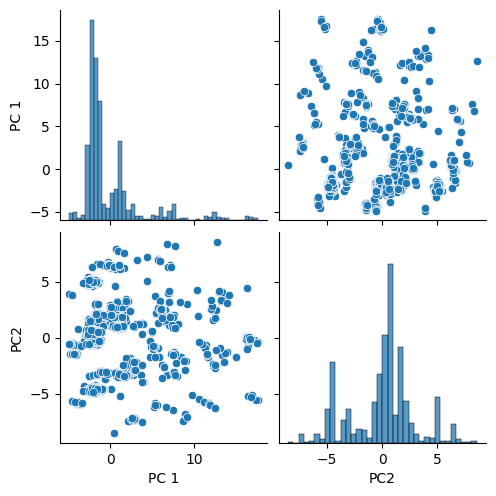

<Figure size 800x800 with 0 Axes>

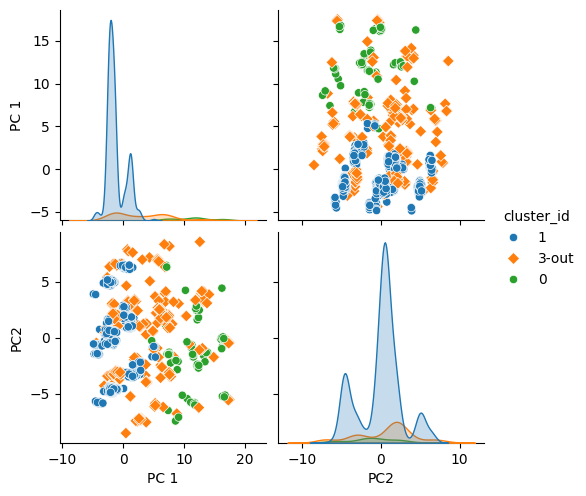

<Figure size 800x800 with 0 Axes>

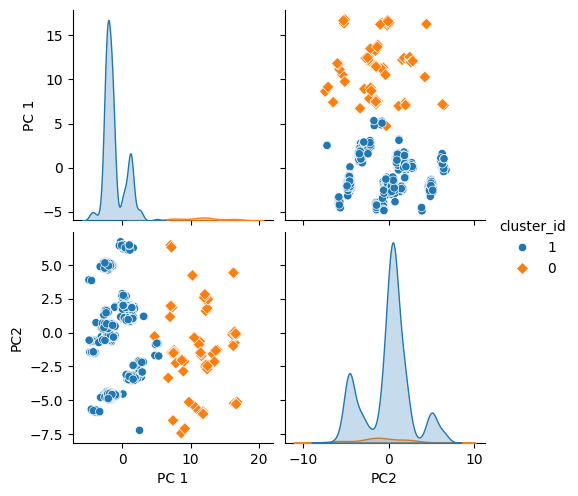

In [16]:
# OPTIMAL VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

#PAIR PLOT OPTIMAL with OUTLIERS
df_pca['cluster_id'] = optimal_cluster.loc[:, optimal_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT OPTIMAL without OUTLIERS
df_pca['cluster_id'] = optimal_inlier.loc[:, optimal_inlier.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])